# Time Series Analysis of Amazons's Stock Price

### Forecasting with an ARIMA model

In this notebook we will have a look at applying a time series model to the stock prices. More specifically, an ARIMA model. We implement a **grid search** to select the optimal parameters for the model and forecast the next 12 months.

### The  ARIMA (p,d,q) model

ARIMA(p,d,q) forecasting equation: ARIMA models are, in theory, the most general class of models for forecasting a time series which can be made to be “stationary” by differencing (if necessary). A random variable that is a time series is **stationary** if its statistical properties are all constant over time.  A stationary series has no trend, its variations around its mean have a constant amplitude, and its short-term random time patterns always look the same in a statistical sense.  The latter condition means that its autocorrelations (correlations with its own prior deviations from the mean) remain constant over time.  A random variable of this form can be viewed (as usual) as a combination of signal and noise, and the signal (if one is apparent) could be a pattern of fast or slow mean reversion, or sinusoidal oscillation, or rapid alternation in sign, and it could also have a seasonal component.  An ARIMA model can be viewed as a “filter” that tries to separate the signal from the noise, and the signal is then extrapolated into the future to obtain forecasts.

The ARIMA forecasting equation for a stationary time series is a linear (i.e., regression-type) equation in which the predictors consist of lags of the dependent variable and/or lags of the forecast errors.  

The acronym ARIMA stands for Auto-Regressive Integrated Moving Average. Lags of the stationarized series in the forecasting equation are called "autoregressive" terms, lags of the forecast errors are called "moving average" terms, and a time series which needs to be differenced to be made stationary is said to be an "integrated" version of a stationary series.

A **nonseasonal** ARIMA model is classified as an "ARIMA(p,d,q)" model, where:

-**p** is the number of autoregressive terms,

-**d** is the number of nonseasonal differences needed for stationarity

-**q** is the number of lagged forecast errors in the prediction equation.


The first (and most important) step in fitting an ARIMA model is the determination of the order of differencing needed to stationarize the series. Normally, the correct amount of differencing is the lowest order of differencing that yields a time series which fluctuates around a well-defined mean value and whose autocorrelation function (ACF) plot decays fairly rapidly to zero, either from above or below. If the series still exhibits a long-term trend, or otherwise lacks a tendency to return to its mean value, or if its autocorrelations are are positive out to a high number of lags (e.g., 10 or more), then it needs a higher order of differencing. 

## Downloading the data 

I will be using Amazon's historic monthly stock price, which can be downloaded at the link: https://finance.yahoo.com/quote/AMZN/history?period1=1391904000&period2=1581206400&interval=1mo&filter=history&frequency=1mo.
Yahoo finance has various other stocks to choose from.

**Import Libraries**

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
import seaborn as sns
import statsmodels.api as sm
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA, ARMA
import warnings
warnings.filterwarnings("ignore")

Now it's time to import the dataset and view it. We do so using the pandas library and its read_csv function.

In [2]:
data = pd.read_csv('/Users/lukabeverin/Downloads/AMZN-5.csv')
#head is used to view the first 5 observations
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-03-01,358.739990,383.109985,330.880005,336.369995,336.369995,75253500
1,2014-04-01,338.089996,348.299988,288.000000,304.130005,304.130005,138278700
2,2014-05-01,304.130005,314.869995,284.380005,312.549988,312.549988,78579200
3,2014-06-01,312.589996,340.720001,303.839996,324.779999,324.779999,76580100
4,2014-07-01,325.859985,364.850006,311.859985,312.989990,312.989990,99426000


We are only interested in the Close price. Also, we need to set the Date as the index for the dataframe. 

In [3]:
df = data[['Date','Close']]
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
df.head()

,Close
Date,
2014-03-01,336.369995
2014-04-01,304.130005
2014-05-01,312.549988
2014-06-01,324.779999
2014-07-01,312.989990


**Plot Amazon's stock prices**

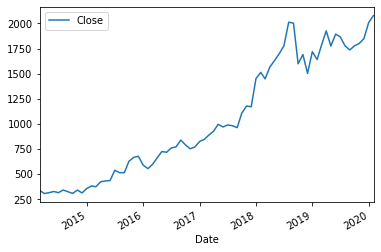

In [4]:
df.plot(style="-")

## ARIMA Parameter Grid Search

When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q) that optimize a metric of interest. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. In this section, we will resolve this issue by writing Python code to programmatically select the optimal parameter values for our ARIMA(p,d,q) time series model.

We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, we fit a ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let’s begin by generating the various combination of parameters that we wish to assess:

In [7]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
#seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as **grid search** (or hyperparameter optimization) for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the **AIC (Akaike Information Criterion)** value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters. After fitting each SARIMAX()model, the code prints out its respective AIC score.

In [26]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

aic= []
parameters = []


for param in pdq:
    #for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            #seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)

            results = mod.fit()
            # save results in lists
            aic.append(results.aic)
            parameters.append(param)
            #seasonal_param.append(param_seasonal)

            print('ARIMA{} - AIC:{}'.format(param, results.aic))
        except:
            continue
            
# find lowest aic            
index_min = min(range(len(aic)), key=aic.__getitem__)             

print('The optimal model is: ARIMA{} - AIC:{}'.format(parameters[index_min], aic[index_min]))

The optimal model is: ARIMA(0, 2, 1) - AIC:853.8946396688659


### Fit ARIMA (0,2,1) model


In [30]:
model = ARIMA(df, order=parameters[index_min])
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                   71
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -424.744
Method:                       css-mle   S.D. of innovations             93.062
Date:                Fri, 20 Mar 2020   AIC                            855.489
Time:                        22:26:51   BIC                            862.277
Sample:                             2   HQIC                           858.188
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3576      0.528      0.678      0.498      -0.677       1.392
ma.L1.D2.Close    -1.0000      0.039    -25.879      0.000      -1.076      -0.924
                                    

## Forecast the Next 12 Months

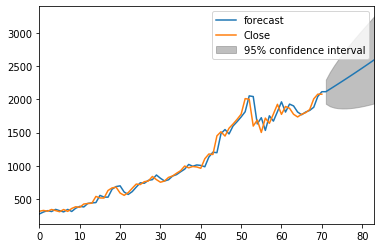

In [31]:
model_fit.plot_predict(start=2, end=len(df)+12)
plt.show()

In [32]:
pred = model_fit.predict(start=2, end=len(df)+12, typ='levels')
pred.tail()

79    2432.155250
80    2473.151508
81    2514.505345
82    2556.216762
83    2598.285759
dtype: float64

**References** 

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3